# Wasserstein-based clustering

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from wkmeans import WKMeans
from MAslope import ma_slope

In [5]:
# Data
df = pd.read_parquet("btc_binance_1d.parquet")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [ ]:
# The number of clusters
k = 2

# Features computation
df_features = pd.DataFrame(index=df.index)

# Log returns
df_features['Returns'] = np.log(df['Close'] / df['Close'].shift())

for i in [7, 14, 21, 30]:
    df_resultado = ma_slope(df_test, ma_type='SMA', length=3, slope_mode='Raw')

df_features.dropna(inplace=True)

In [4]:
df_features.head()

,Returns,LagRet1,LagRet2,LagRet3,LagRet4,LagRet5,LagRet6,LagRet7,LagRet8,LagRet9,LagRet10
Date,,,,,,,,,,,
2017-08-28,0.017635,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665,-0.042113
2017-08-29,0.044756,0.017635,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053,0.007665
2017-08-30,-0.007075,0.044756,0.017635,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351,-0.013053
2017-08-31,0.036588,-0.007075,0.044756,0.017635,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958,-0.017351
2017-09-01,0.023018,0.036588,-0.007075,0.044756,0.017635,-0.006344,0.013172,-0.008219,0.047933,0.018154,0.005958


In [5]:
# Define dataset
dataset = df_features.values

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
df_features['wk'] = wkmeans.predict(dataset)

In [6]:
df['cluster'] = df_features['wk']
df.dropna(inplace=True)

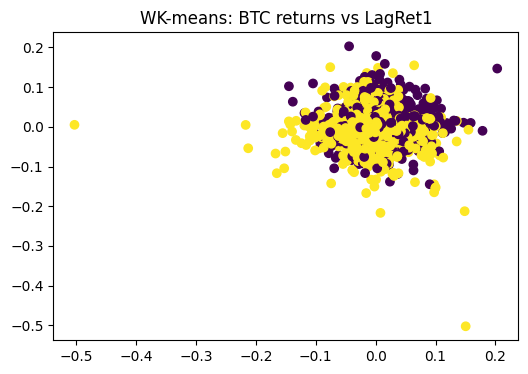

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(6, 4))

axes.scatter(df_features['Returns'].values, 
            df_features['LagRet1'].values,
            c=df_features['wk'].values)

axes.set_title('WK-means: BTC returns vs LagRet1')
plt.show()

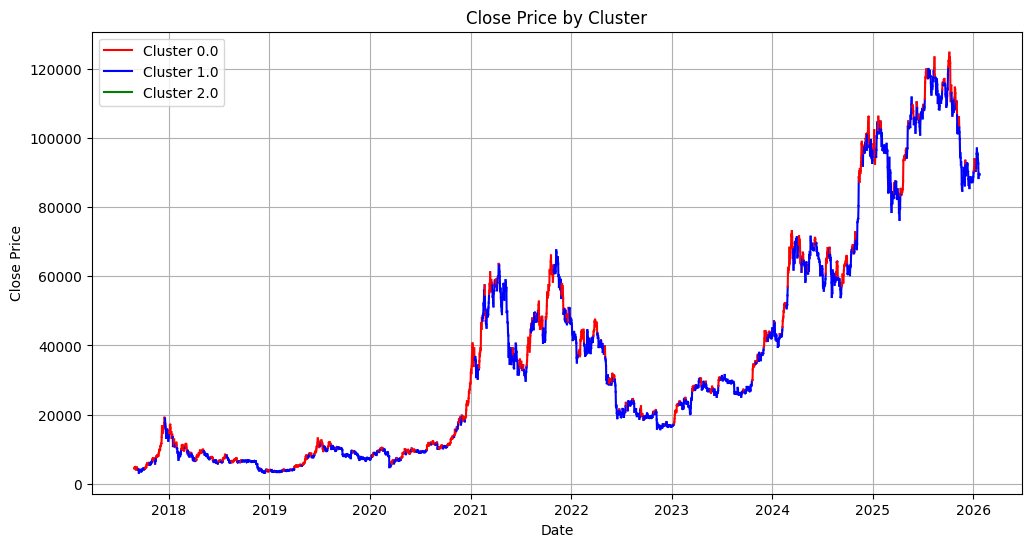

In [8]:
# Define colors for clusters
colors = {0.0: "red", 1.0: "blue", 2.0: "green"}

plt.figure(figsize=(12,6))

# Iterate through consecutive points and draw line segments
for i in range(len(df)-1):
    x_vals = df.index[i:i+2]
    y_vals = df["Close"].iloc[i:i+2]
    cluster = df["cluster"].iloc[i]
    plt.plot(x_vals, y_vals, color=colors[cluster], linestyle="-")

plt.title("Close Price by Cluster")
plt.xlabel("Date")
plt.ylabel("Close Price")
# Add legend handles manually
for cluster, color in colors.items():
    plt.plot([], [], color=color, label=f"Cluster {cluster}")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. Base continua (gris) ---
close_neutral = df['Close']

# --- 2. Series por cluster ---
colors = {0.0: "red", 1.0: "blue", 2.0: "green"}
close_cluster = {}

for c in colors.keys():
    # Creamos máscara: el punto actual o el siguiente pertenece al cluster
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

# --- 3. Crear subplots ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Precio Multicolor por Cluster", "Cluster asignado")
)

# --- Panel superior: Precio ---
# Línea gris base
fig.add_trace(go.Scatter(
    x=df.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

# Líneas coloreadas por cluster
for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=df.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

# --- Panel inferior: mostrar cluster como línea discreta ---
fig.add_trace(go.Scatter(
    x=df.index, y=df['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

# --- Layout ---
fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Detector de Clusters Interactivo",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show()